# Fine-tuning Whisper on Speech Pathology Dataset

## Goal

The goal of the Cleft Palate project (name TBD) at Vanderbilt DSI is to classify audio clips of patients' voices as containing hypernasality (a speech impediment) or not. The patients with hypernasality can then be recommended for speech pathology intervention. This is currently evaluated by human speech pathologists, which requires access to these medical providers. Our hope is to train a model that can classify this speech impediment for expedited patient access to a speech pathologist.

## Model

In this notebook we train the Whisper model with a Sequence Classification Head.

## Data

The data in this notebook is publicly available voice recordings featuring hypernasality and control groups. In the future we hope to train our model on private patient data from Vanderbilt University Medical Center (VUMC).

In [ ]:
# FOR GOOGLE DRIVE USE ONLY
!pip install torch
!pip install datasets
!pip install librosa
!pip install transformers

In [ ]:
# import libraries
import datasets
from datasets import load_dataset, DatasetDict,  Audio
import pandas as pd
import os
import glob
import librosa
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
from transformers import WhisperModel, WhisperFeatureExtractor, AdamW
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_from_disk

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load PyTorch datasets

If you have not already, run the `01-load-data.ipynb` notebook to create the files "../data/train_dataset.pt", "../data/val_dataset.pt", and "../data/test_dataset.pt". Then, load them using the cell below.

In [ ]:
# load data from disk
train_audio_dataset = load_from_disk('/content/drive/MyDrive/cleft_palate/content/cleft_palate/data/public_samples/extracted_files/train_dataset')
test_audio_dataset = load_from_disk('/content/drive/MyDrive/cleft_palate/content/cleft_palate/data/public_samples/extracted_files/test_dataset')
val_audio_dataset = load_from_disk('/content/drive/MyDrive/cleft_palate/content/cleft_palate/data/public_samples/extracted_files/val_dataset')

In [ ]:
model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)


In [ ]:
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

Training for Whisper model.

In [ ]:

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits



In [ ]:
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4) # Using L2 regularization
criterion = nn.CrossEntropyLoss()

In [ ]:
#@title Method of earlystopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.min_delta = min_delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), '/content/drive/MyDrive/cleft_palate/content/cleft_palate/model/whisper_base_model.pt')
        self.val_loss_min = val_loss

def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    early_stopping = EarlyStopping(tolerance=5)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze().to(device)
            decoder_input_ids = decoder_input_ids.squeeze().to(device)
            labels = labels.view(-1).type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        val_loss, val_accuracy, val_f1, _, _ = evaluate(model, val_loader, device)
        val_losses.append(val_loss)

        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
        print("========================================================================================")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses

In [ ]:
def evaluate(model, data_loader, device):
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze().to(device)
            decoder_input_ids = decoder_input_ids.squeeze().to(device)
            labels = labels.view(-1).type(torch.LongTensor).to(device)

            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            _, preds = torch.max(logits, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

def cross_validate(model_class, dataset, k_folds=5, num_epochs=50, batch_size=8, device='cuda'):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_results = []
    global train_losses, val_losses
    best_model_state = None
    best_val_f1 = 0.0

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold+1}/{k_folds}')

        # Convert numpy.int64 indices to Python int
        train_ids = [int(idx) for idx in train_ids]
        val_ids = [int(idx) for idx in val_ids]

        # Train and evaluate
        train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)

        val_loss, val_accuracy, val_f1, _, _ = evaluate(model, val_loader, device)
        fold_results.append({
            'fold': fold+1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1
        })

        print(f'Fold {fold+1} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'/content/drive/MyDrive/cleft_palate/content/cleft_palate/model/whisper_base_best_model_fold_{fold+1}.pt')

    if best_model_state is not None:
        torch.save(best_model_state, '/content/drive/MyDrive/cleft_palate/content/cleft_palate/model/whisper_base_final_best_model.pt')

    return fold_results

In [ ]:
results = cross_validate(SpeechClassifier, train_dataset, k_folds=5, num_epochs=50, batch_size=8, device=device)

Fold 1/5
Epoch 1/50, Batch 8/13, Train Loss: 0.8507
Epoch 1/50, Val Loss: 0.6584, Val Accuracy: 0.5778, Val F1: 0.5744
Epoch 2/50, Batch 8/13, Train Loss: 0.4022
Epoch 2/50, Val Loss: 0.5950, Val Accuracy: 0.6444, Val F1: 0.6429
Epoch 3/50, Batch 8/13, Train Loss: 0.6284
Epoch 3/50, Val Loss: 0.4863, Val Accuracy: 0.7333, Val F1: 0.7332
Epoch 4/50, Batch 8/13, Train Loss: 0.3330
Epoch 4/50, Val Loss: 0.4587, Val Accuracy: 0.7778, Val F1: 0.7777
Epoch 5/50, Batch 8/13, Train Loss: 0.3145
Epoch 5/50, Val Loss: 0.3960, Val Accuracy: 0.8000, Val F1: 0.7996
Epoch 6/50, Batch 8/13, Train Loss: 0.1124
Epoch 6/50, Val Loss: 0.4374, Val Accuracy: 0.7778, Val F1: 0.7777
Epoch 7/50, Batch 8/13, Train Loss: 0.0513
Epoch 7/50, Val Loss: 0.4439, Val Accuracy: 0.8222, Val F1: 0.8221
Epoch 8/50, Batch 8/13, Train Loss: 0.1378
Epoch 8/50, Val Loss: 0.5022, Val Accuracy: 0.8667, Val F1: 0.8666
Epoch 9/50, Batch 8/13, Train Loss: 0.0880
Epoch 9/50, Val Loss: 0.5697, Val Accuracy: 0.8444, Val F1: 0.8441
E

### Evaluation

#### Validation Set

Evaluate how our model performs on the validation set.

In [ ]:
import torch
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

best_fold = max(results, key=lambda x: x['val_accuracy'])

#VALIDATION
state_dict = torch.load('/content/drive/MyDrive/cleft_palate/content/cleft_palate/model/whisper_base_final_best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

val_loss, val_accuracy, val_f1, all_labels, all_preds = evaluate(model, val_loader, device)

In [ ]:
#VALIDATION
print(classification_report(all_labels, all_preds))
print(f'Accuracy: {accuracy_score(all_labels, all_preds):.4f}')

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.82      0.78      0.80        23

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45

Accuracy: 0.8000


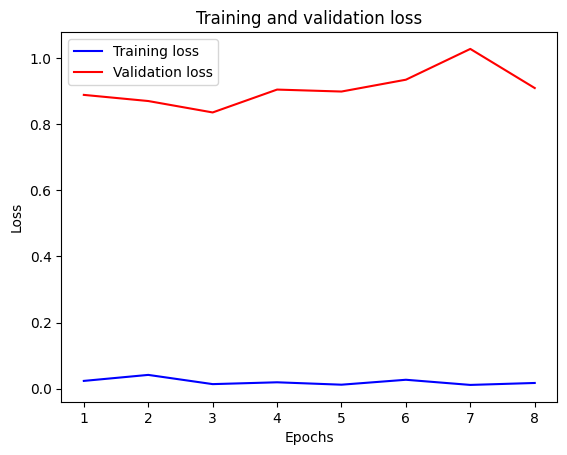

In [ ]:
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()